# Simple orders analysis

🚀 We are finally ready to start analysing our `orders` dataset!

Our objective is to get an initial understanding of:
- `orders` properties
- their associated `review_scores`

In [59]:
# Import Modules 

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
# Import your newly coded _order_ training sel

from olist.order import Order

# Change `with_distance_seller_customer` to False..
# ..if you have not completed the optional part of challenge 1 yet
orders = Order().get_training_data(with_distance_seller_customer=True)

AttributeError: 'NoneType' object has no attribute 'merge'

In [0]:
assert(orders.shape ==(95872, 13))

## 1 - Inspect features

👉 Print summary statistics of each column of the order dataset (then focus in particular on `wait_time`)

In [ ]:
orders.describe()

In [ ]:
orders.info()

In [ ]:
# YOUR CODE HERE
for variable in orders.select_dtypes(exclude = ["object"]).columns:
    print(f"----- Distribution of {variable} : -----")
    sns.histplot(orders[variable])
    plt.show()


📈 Plot histograms to get a sense of the distribution of each numerical feature.

In [ ]:
# YOUR CODE HERE
g = sns.FacetGrid(data=orders, col="review_score")
g.map(plt.hist, "wait_time")

👀 In particular, create a `sns.FacetGrid()` of histograms for each `review_score` vs. `wait_time`

In [ ]:
# YOUR CODE HERE
sns.kdeplot(orders['price'])
sns.kdeplot(orders['freight_value'])
sns.kdeplot(orders['distance_seller_customer'])

❓ What do you notice for the variables `price` and `freight_value` ? 

❓ Have a look at the  `distance_seller_customer` feature if you have created it in `order.py`

In [54]:
# YOUR CODE HERE

❓Inspect the various correlations between features: which feature seems to the most correlated with `review_score`?

<details>
    <summary>▸ Hint</summary>

* Use `DataFrame.corr()` combined with `sns.heatmap()` and `cmap='coolwarm'`
* Have a look at the absolute values of the correlation coefficients of `review_score` vs. each feature,
    * the higher the coefficient, the more one given feature is correlated (positively or negatively) with the `review_score`

</details>

<AxesSubplot:>

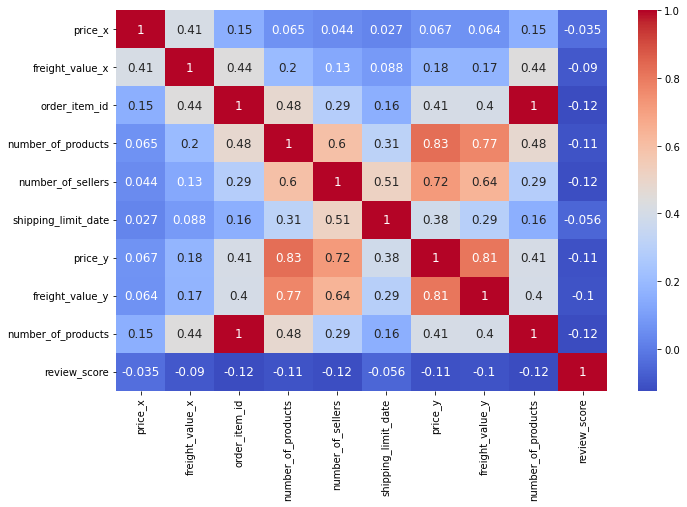

In [55]:
# YOUR CODE HERE
plt.figure(figsize=(11,7))
sns.heatmap(orders.corr(), cmap='coolwarm', annot = True, annot_kws={"size": 12})

* 😏 _Captain Obvious :_
    * `review_score` is 100% correlated to itself 
    * and strongly correlated to `dim_is_one_star` and `dim_is_five_star`...
* ⚠️ The two next highest correlation coefficients with respect to the `review_score` are :
    * `wait_time` : - 34 %
    * `delay_vs_expected` : 27 %

## 2 - Simple regression of `review_score` against delivery duration

👉 So, it seems that `review_score` is mostly correlated with `wait_time` (= - 34%) and `delay_vs_expected` (27%).

🎨 Let's investigate these correlations  with `seaborn`

### 2.1 Plots
❓ In one figure, create 2 subplots, that regress `review_score` on `wait_time` and `delay_vs_expected` respectively.

<u>Tips</u>:

- Reduce your dataframe to a random sub-`sample of 10,000 rows` for speed purposes (a good practice in data exploration)
- Use `DataFrame.sample()` with a fixed `random_state` to avoid changing the sample at each execution if needed
- Use `sns.regplot()` to plot the `regression lines`
- Add some `y_jitter` parameters to better visualize the scatterplot density
- Limit `xlim` and `ylim` to hide outliers

In [46]:
# YOUR CODE HERE
sample = orders.sample(10000, random_state=42)

TypeError: Cannot cast array data from dtype('float64') to dtype('<m8[ns]') according to the rule 'same_kind'

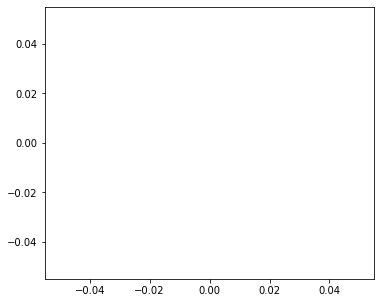

In [48]:
# YOUR CODE HERE
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.regplot(x = sample.wait_time, y= sample.review_score, y_jitter=.1)
plt.xlim(right=70)
plt.ylim(bottom=0)

plt.subplot(1,2,2)
sns.regplot(x = sample.delay_vs_expected, y= sample.review_score, y_jitter=.1)
plt.xlim(right=70)
plt.ylim(bottom=0)

ℹ️ What did `regplot` do ? 

👉 It tried to perform a `Linear Regression` of the `review_score` vs. `wait_time` and `delay_vs_exp` <br/> *(Cf. Day 03 - Linear Regression tomorrow)*

🧐 It doesn't look so interpretable, does it ?

👉 You are right: we have only 5  different review scores which can be interpreted as a categorical variable with five different possible values (for example: "very bad", "bad", "average", "good" and "very good") that we are trying to regress against two continuous values that are `review_scores` and `wait_time`.

👀 However, based on the regression lines, we can see a very intuitive pattern: the longer the waiting time and/or the delay, the lower the review score - Well, not surprising. But how fast does the review score decrease ?


### 2.2 Interpretation

❓Try to visually "compute" the `slope` of each curve. 

✍️ Write down, in plain English, how you would interpret these coefficients if you were to explain it to a non-data-educated audience.

> YOUR ANSWER HERE

<details>
    <summary>▸ Answer</summary>


- `Slope wait_time ≈ -0.05` : "For each additional day waiting for an order to be delivered, the review score on average is reduced by 0.05"
- `Slope delay ≈ -0.1` : "For each additional day waiting for an order to be delivered _after the ETA_, the review score on average is reduced by 0.1"

❓ Are you surprised that the delay seems more impactful than the waiting time ? 
    
👉If yes, think about it twice: you may be impatient to receive your order and would like a small wait time, but you would be even more disappointed to receive your package after the expected delivery date !
        
</details>

### 2.3 Inferential analysis

Even if we had used all 100,000 orders for these regplots, these orders represent 16 months of data after all...

⚠️⚠️⚠️ **How certain** are we that these coefficients are **statistically significant**? ⚠️⚠️⚠️

⚡️ <u> Questions about the statistical significance of these coefficients: </u>

* Are these coefficients able to generalize well to future orders (all else being equal) ? (*Ideal answer: Yes*) 
* Are we sure that these coefficients do not simply capture random fluctuations due to the limited observation period ? (*Ideal answer: No*) 

🧐 We need to estimate the **`confidence interval`** around the mean value for these two slopes  :
$$slope_{wait} = -0.05 ± \ ?? \ \text{[95% interval]} $$
$$slope_{delay} = -0.1 ± \ ?? \ \text{[95% interval]} $$

⭐️ Fortunately, `Seaborn` already computes this 95% confidence interval for us with a shaded blue cone around the regression line!

❓Use `Seaborn` `regplot` to visualize the two confidence intervals:
- Change the `size of your sample dataset`: 
    - Notice how the slope may change as the sample size becomes smaller. 
    - What about the confidence interval?
- Change the `size of the confidence interval` by playing with the regplot parameter called `ci` (95% by default)

TypeError: Cannot cast array data from dtype('float64') to dtype('<m8[ns]') according to the rule 'same_kind'

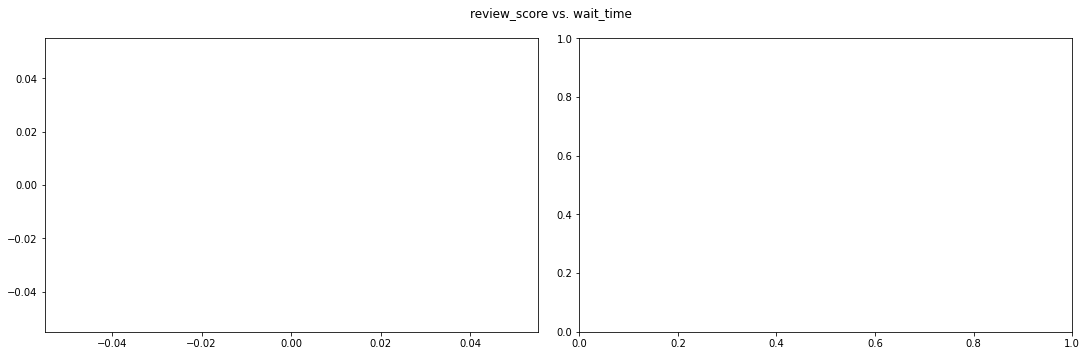

In [49]:
# YOUR CODE HERE
sample = orders.sample(100, random_state=42)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle('review_score vs. wait_time')
fig.tight_layout()

sns.regplot(x = sample.wait_time, y= sample.review_score, y_jitter=.1, ci=99, ax = axes[0])
axes[0].set_xlim(right=70)
axes[0].set_ylim(bottom=0)
axes[0].set_title("Sample size: small, Confidence Interval 99%")


sns.regplot(x = orders.wait_time, y= orders.review_score, y_jitter=.1, ci=99, ax = axes[1])
axes[1].set_xlim(right=70)
axes[1].set_ylim(bottom=0)
axes[1].set_title("Full dataset (100000 datapoints), Confidence Interval 99%")

plt.show();

🔎 Interpretation:

* **Null Hypothesis** $H_0$ : "this variable does not influence the review score", a.k.a its coefficient is equal to zero

When plotting all our datapoints:
- The 95% confidence interval for the slope does not contain the value 0.
    - 👉 We are `95% confident that slower deliveries are associated with weaker reviews`.
- The **`p-value`** associated with the null hypothesis "the delivery time is almost zero" is lower than 5%
    - 👉 We can safely reject this null hypothesis and consider the **`alternative hypothesis`** = `"the delivery time has an impact on the review score"` 

🔥 Our findings are said to be **statistically significant**. 

⚠️ However, **correlation does NOT imply causality**. 

- It can be inherently slower to deliver certain products (e.g.heavy products)
    - These categories of products will often have a low review_score, not matter how long their delivery time is. 

👉 Identifying **confounding factor** is crucial and cannot be done with a simple univariate regression. 

🗓 Cf. `Lecture 3 - Linear Regression` : we will talk about **`multivariate linear regression`**. 
</details>



---
🏁 Congratulations! 

🙏 Don't forget to `commit` and `push` your notebook